In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import numba
import scipy.optimize

def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['legend.framealpha'] = 0.5
    plt.rcParams['legend.frameon'] = True
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['pcolor.shading'] = 'nearest'

reset_plt(20,15)

@numba.jit(nopython=True, fastmath=True, parallel=True)
def simulate_single(sizes, steps):
    sizes_array = np.zeros(len(sizes) * steps, dtype=np.int32).reshape(len(sizes), steps)
    extent_array = np.empty(len(sizes) * steps, dtype=np.int32).reshape(len(sizes), steps)
    for n in numba.prange(len(sizes)):
        N = sizes[n]
        system = (np.random.rand(N*N).reshape((N,N)) > 0.3).astype(np.int8)
        queue = []
        def add_grain(i1, i2):
            if i1 < 0 or i1 >= N or i2 < 0 or i2 >= N:
                return
            system[i1, i2] += 1
            if system[i1, i2] == 2:#just toppled
                queue.append((i1, i2))
                
        for i in range(steps):
            minx = np.inf 
            miny = np.inf 
            maxx = -np.inf
            maxy = -np.inf
            y = np.random.randint(N)
            x = np.random.randint(N)
            add_grain(x, y)
            while queue:
                i1, i2 = queue.pop()
                minx = min(minx, i1)
                maxx = max(maxx, i1)
                miny = min(miny, i2)
                maxy = max(maxy, i2)
                system[i1, i2] -= 2
                for nbor in range(2):
                    chosen_nbor = np.random.randint(4)
                    if chosen_nbor==0: add_grain(i1 - 1, i2)
                    if chosen_nbor==1: add_grain(i1 + 1, i2)
                    if chosen_nbor==2: add_grain(i1, i2 - 1)
                    if chosen_nbor==3: add_grain(i1, i2 + 1)

                sizes_array[n, i] += 1
                if system[i1, i2] > 1:
                    queue.append((i1, i2))
            extent_array[n, i] = max((1+maxx-minx), (1+maxy-miny)) \
                                       if maxx > -np.inf \
                                       else 0
            if not ((i + 1) % (steps//10)):
                print("Finished iteration ", i + 1, " for system with N =", sizes[n])
    return sizes_array, extent_array

In [25]:
%%time
Ns = np.array([6, 13, 25, 50, 100, 200, 400, 800])
sizes_array, extent_array = simulate_single(Ns, int(1e6))

Finished iteration  100000  for system with N = 6
Finished iteration  200000  for system with N = 6
Finished iteration  300000  for system with N = 6
Finished iteration  100000  for system with N = 13
Finished iteration  400000  for system with N = 6
Finished iteration  500000  for system with N = 6
Finished iteration  600000  for system with N = 6
Finished iteration  200000  for system with N = 13
Finished iteration  700000  for system with N = 6
Finished iteration  800000  for system with N = 6
Finished iteration  100000  for system with N = 25
Finished iteration  900000  for system with N = 6
Finished iteration  300000  for system with N = 13
Finished iteration  1000000  for system with N = 6
Finished iteration  400000  for system with N = 13
Finished iteration  500000  for system with N = 13
Finished iteration  200000  for system with N = 25
Finished iteration  600000  for system with N = 13
Finished iteration  700000  for system with N = 13
Finished iteration  800000  for system w

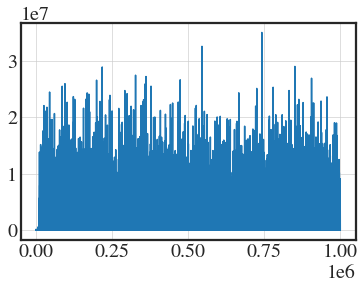

In [26]:
plt.plot(sizes_array[-1])

Vi ser at selv for det aller største system er opstart tiden neglicibel. Derfor ignorerer vi at det giver en lille smule bias til statistikken

In [27]:
np.save("sizes_boundary.npz", sizes_array)

In [28]:
np.save("extent_boundary.npz", extent_array)

In [29]:
sizes_array = np.load("sizes_boundary.npz.npy")
extent_array = np.load("extent_boundary.npz.npy")

# Løsning 1: Fitting til logaritmisk data

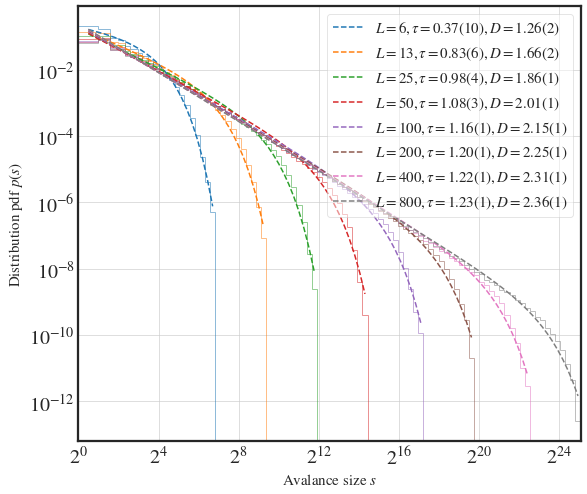

In [43]:
plt.figure(figsize=(9,8))
bins = np.unique((2**np.linspace(0, np.log2(np.max(sizes_array)), 100)).astype(int))
bin_centres = np.sqrt(bins[1:]*bins[:-1])
#small_fltr = bin_centres > 5
taus = []
Ds = []
for i, (N, avalances) in enumerate(zip(Ns, sizes_array)):
    converged_data = np.array(avalances[10**3:])
    converged_data = converged_data[converged_data!=0]
    prop, _ = np.histogram(converged_data, bins=bins, density=True)
    prop, bins, _ = plt.hist(converged_data, histtype=u'step',bins=bins, density=True, alpha=0.5)
    fltr = prop != 0
    def func(s, tau, D, norm): 
        return 1/s**tau*np.exp(-s/N**D)*norm

    fit, cov = scipy.optimize.curve_fit(lambda *x: np.log(func(*x)), bin_centres[fltr], np.log(prop[fltr]), p0=[1.2, 2.3, 0.25])
    taus.append(fit[0])
    Ds.append(fit[1])
    sigma = np.sqrt(np.diag(cov))
    plt.plot(bin_centres[fltr], (func(bin_centres, *fit))[fltr], color="C"+str(i), label=fr"$L={N}, \tau={fit[0]:.2f}({sigma[0]*1e2:.0f}), D={fit[1]:.2f}({sigma[1]*1e2:.0f})$", linestyle="--")
plt.xscale("log", base=2)
plt.yscale("log")
plt.xlim(1, max(bins))
plt.legend(loc="upper right", facecolor='white', frameon = True)
plt.xlabel("Avalance size $s$")
plt.ylabel("Distribution pdf $p(s)$")
plt.savefig("avalance_distribution.pdf")

# Check for consistent fit values
This does imply that the propper D value is probably a bit higher than the 2.36 calculated

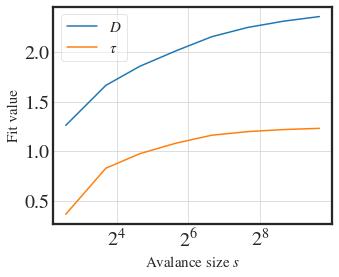

In [37]:
plt.figure(figsize=(5,4))
plt.plot(Ns, Ds, label=r"$D$")
plt.plot(Ns, taus, label=r"$\tau$")
plt.xscale("log", base=2)
plt.xlabel("Avalance size $s$")
plt.ylabel("Fit value")
plt.legend()
plt.savefig("fit_convergence.pdf")

# Solution 2: Data collapse

<ipython-input-47-a246d28cfd7a>:2: RuntimeWarning: invalid value encountered in sqrt
  bin_centres = np.sqrt(bins[1:]*bins[:-1])


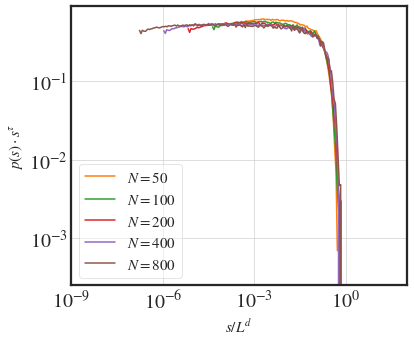

In [47]:
bins = np.unique((2**np.linspace(3, np.log2(np.max(sizes_array)*100), 200)).astype(int))
bin_centres = np.sqrt(bins[1:]*bins[:-1])
converged_data = sizes_array[:,10**5:]
props = np.apply_along_axis(lambda a: np.histogram(a, bins=bins, density=True)[0], 1, converged_data)

tau = 1.27
D=2.65
plt.figure(figsize=(6,5))
for i, (N, avalances) in enumerate(zip(Ns, sizes_array)):
    if i > 2:
        plt.loglog(bin_centres/N**D, (props[i]*bin_centres**tau), color = "C"+str(i-2) , label=fr"$N={N}$")
#plt.xlim()
plt.xscale("log")
#plt.ylim(1e-2, 1)
plt.xlim(10**-9, 1e2)
plt.legend()
plt.xlabel("$s/L^d$")
plt.ylabel(r"$p(s)\cdot s^\tau$")
plt.tight_layout()
plt.savefig("data_collapse.pdf")

# Avalance scaling
To fit, we need to (1) use only the data with resonable avalance sizes so that we are not affected by small deviations in the avalance size definition, and also (2) not be completely biased by small avalances which compose by far the most avalances

<ipython-input-50-c6376b1eb6aa>:8: RuntimeWarning: invalid value encountered in log
  fit, cov = scipy.optimize.curve_fit(lambda *x: np.log(f(*x)), bin_centres, np.log(avg), p0=[1, 2])


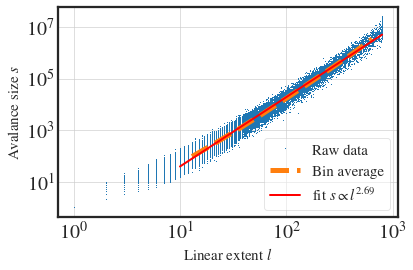

In [50]:
f = lambda x, c, d: c*x**d
extents = extent_array[-1]
sizes = sizes_array[-1]
bins = np.unique((np.logspace(1, np.log10(max(extents)-1), 10)).astype(int))
bin_centres = (bins[1:]+bins[:-1])/2
avg = (np.histogram(extents, bins, weights=sizes.astype(np.float64))[0] /
       np.histogram(extents, bins)[0])
fit, cov = scipy.optimize.curve_fit(lambda *x: np.log(f(*x)), bin_centres, np.log(avg), p0=[1, 2])
plt.plot(extents[::10], sizes[::10], ',', label="Raw data", alpha=1)
plt.plot(bin_centres, avg, "--", lw=5, label="Bin average")

plt.xscale("log")
plt.yscale("log")
plt.plot(bins, f(bins, *fit), lw=2, color="red", label=fr"fit $s\propto l^{{{fit[1]:.2f}}}$")
plt.legend()
plt.xlabel("Linear extent $l$")
plt.ylabel("Avalance size $s$")
plt.tight_layout()
plt.savefig("avalance_scaling.png")